# Semivariogram Regularization

In this tutorial we will learn how to regularize semivariogram of dataset consisting irregularly shaped polygons. The procedure of the semivariogram regularization is described in the study: `(1) Goovaerts P., Kriging and Semivariogram Deconvolution in the Presence of Irregular Geographical Units, Mathematical Geology 40(1), 101-128, 2008`.

The main idea is to retrieve the point support semivariogram from the semivariogram of irregular polygons. This is the case in the mining industry, where aggregated blocks are deconvoluted into smaller units, and in epidemiology, where data is aggregated over big administrative units. Or in ecology, where species observations are aggregated over areas.

In this tutorial, we use block data of Breast Cancer incidence rates in Northeastern counties of the U.S. and U.S. Census 2010 data for population blocks.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
  - kriging

- **Package**:
  - `TheoreticalVariogram()`
  - `Blocks()` - described in this tutorial, but this class has been used in **3-5-**
  - `PointSupport()` - described in this tutorial

- **Programming**:
  - Python basics
  - `pandas` basics

## Table of contents

1. Prepare data
2. Set semivariogram parameters
3. Regularize semivariogram
4. Visualize process
5. Export semivariogram

## 1. Prepare data

Data structures for semivariogram regularization are rather complex, and that's why Pyinterpolate has classes merging blocks and point support data. There are two structures:

- `Blocks()`: stores polygon and block data, transforms it, and retrieves centroids,
- `PointSupport()`: performs spatial joins between polygons and points support data and manages internal indexing of those datasets.

In [1]:
import geopandas as gpd

from pyinterpolate import build_experimental_variogram
from pyinterpolate import Blocks
from pyinterpolate import Deconvolution
from pyinterpolate import PointSupport

In [2]:
DATASET = '../data/blocks/cancer_data.gpkg'
OUTPUT = '../data/regularized_variogram.json'
POLYGON_LAYER = 'areas'
POPULATION_LAYER = 'points'
POP10 = 'POP10'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'

In [3]:
blocks = Blocks(
    ds=gpd.read_file(DATASET, layer=POLYGON_LAYER),
    value_column_name=POLYGON_VALUE,
    geometry_column_name=GEOMETRY_COL,
    index_column_name=POLYGON_ID
)

In [4]:
blocks.ds.head()

,FIPS,rate,geometry,representative_points,lon,lat
0,25019,192.2,"MULTIPOLYGON (((2115688.816 556471.24, 2115699...",POINT (2133348.745 558025.221),2.133349e+06,558025.221156
1,36121,166.8,"POLYGON ((1419423.43 564830.379, 1419729.721 5...",POINT (1442153.243 550673.936),1.442153e+06,550673.935704
2,33001,157.4,"MULTIPOLYGON (((1937530.728 779787.978, 193751...",POINT (1958207.252 766008.62),1.958207e+06,766008.620010
3,25007,156.7,"MULTIPOLYGON (((2074073.532 539159.504, 207411...",POINT (2084187.905 556436.412),2.084188e+06,556436.412055
4,25001,155.3,"MULTIPOLYGON (((2095343.207 637424.961, 209528...",POINT (2101100.939 600344.125),2.101101e+06,600344.124709


In [5]:
point_support = PointSupport(
    points=gpd.read_file(DATASET, layer=POPULATION_LAYER),
    blocks=blocks,
    points_value_column=POP10,
    points_geometry_column=GEOMETRY_COL,
    verbose=True
)

In [6]:
point_support.point_support.head()

,geometry,POP10,FIPS,lon,lat,total_POP10
0,POINT (1277277.671 441124.507),1866.0,42049.0,1.277278e+06,441124.5068,262794.0
1,POINT (1277277.671 431124.507),2093.0,42049.0,1.277278e+06,431124.5068,262794.0
2,POINT (1277277.671 421124.507),590.0,42039.0,1.277278e+06,421124.5068,89534.0
3,POINT (1277277.671 411124.507),636.0,42039.0,1.277278e+06,411124.5068,89534.0
4,POINT (1285937.925 446124.507),10191.0,42049.0,1.285938e+06,446124.5068,262794.0


## 2. Set semivariogram parameters

Now, we must set parameters for the areal semivariogram AND point support semivariogram. It is essential to understand data, especially experimental semivariances.

The *step size* and the *maximum search radius* parameters depend on the block data. But we should check the point's semivariogram too, just in case. We won't create meaningful results if point support data is spatially independent.

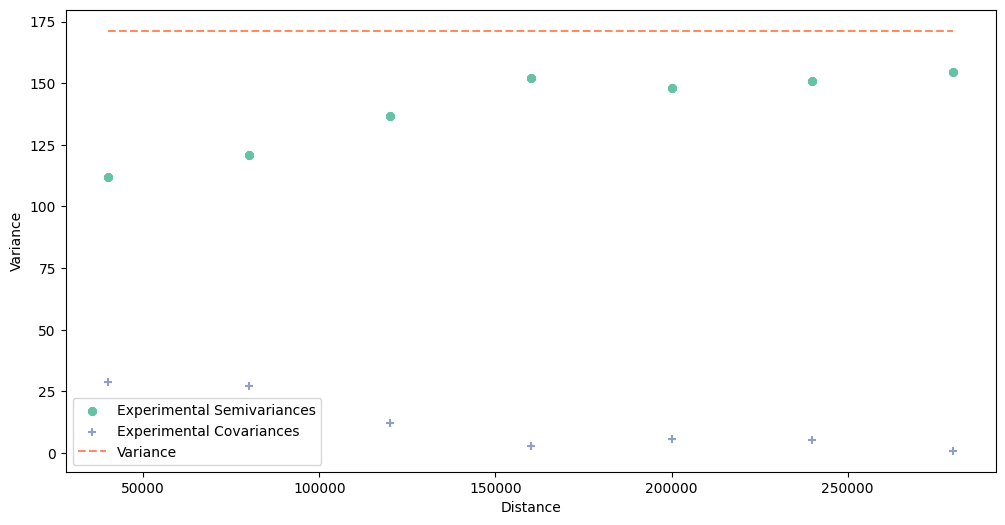

In [7]:
# Check experimental semivariogram of areal data - this cell may be run multiple times
# before you find optimal parameters

maximum_range = 300000
step_size = 40000

dt = blocks.block_data  # x, y, val
exp_semivar = build_experimental_variogram(ds=dt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

exp_semivar.plot()

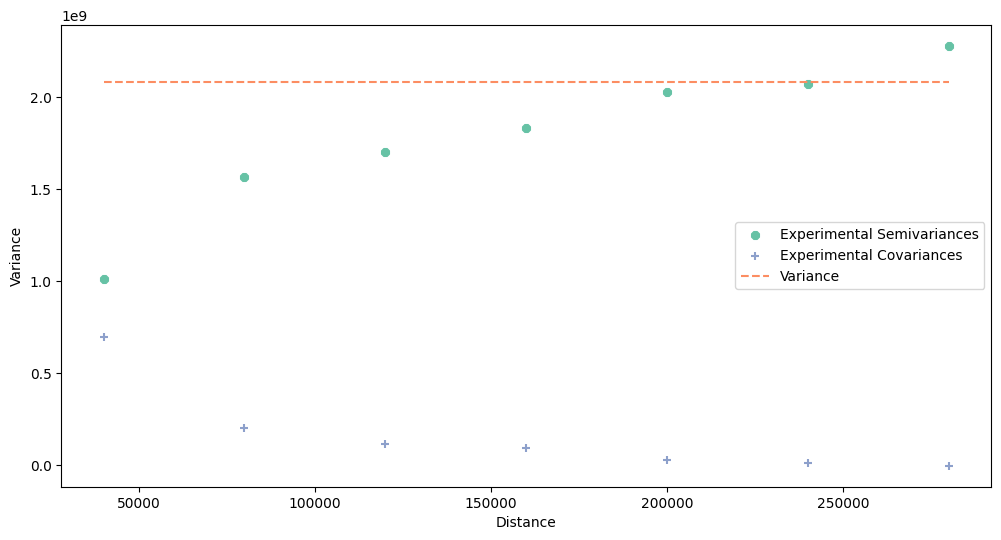

In [8]:
# Check experimental semivariogram of point data - this cell may be run multiple times
# before you find optimal parameters

maximum_point_range = 300000
step_size_points = 20000


pt = point_support.get_points_array()
exp_semivar = build_experimental_variogram(ds=pt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

exp_semivar.plot()

We see that the point support variogram shows semivariance increasing in a function of distance. However, blocks semivariogram increases slowly and starts from the large nugget. Spatial dependency is low in this case, but probably sufficient for modeling.

## 3. Regularize semivariogram

We can move to the next step - deconvolution. We must create the `Deconvolution` object. It iteratively transforms aggregated variogram using point support information. The process is slow, and it is divided into two steps: the initial `fit()` and iterative `transform()`. If you know what you're doing you can perform both steps using method `fit_transform()`.

In [9]:
reg_mod = Deconvolution(verbose=True)

When we `fit()` a model, we have multiple parameters to set:

- **blocks**: `Blocks` object
- **point_support**: `PointSupport` object
- **step_size**: `float` - step size between lags estimated from blocks data!
- **max_range**: `float` - maximal analysis distance
- **nugget**: `float` - nugget, for initial experiments it is better to set it to zero
- **variogram_weighting_method**: `str`
  - equal: no weighting
  - closest: lags at closer distances are more important than distant lags, thus error weights are increased at close distances (semivariogram fits better the first lags)
  - distant: opposite to closest
  - dense: error weight is inversely related to the point pairs within lag. More point pairs - decreased error weight; less point pairs - increased error weight

In [10]:
reg_mod.fit(
    blocks=blocks,
    point_support=point_support,
    step_size=step_size,
    max_range=maximum_range,
    nugget=0,
    variogram_weighting_method='closest',
    models_group='safe'
)

Initial fit of semivariogram
Regularization fit process ends


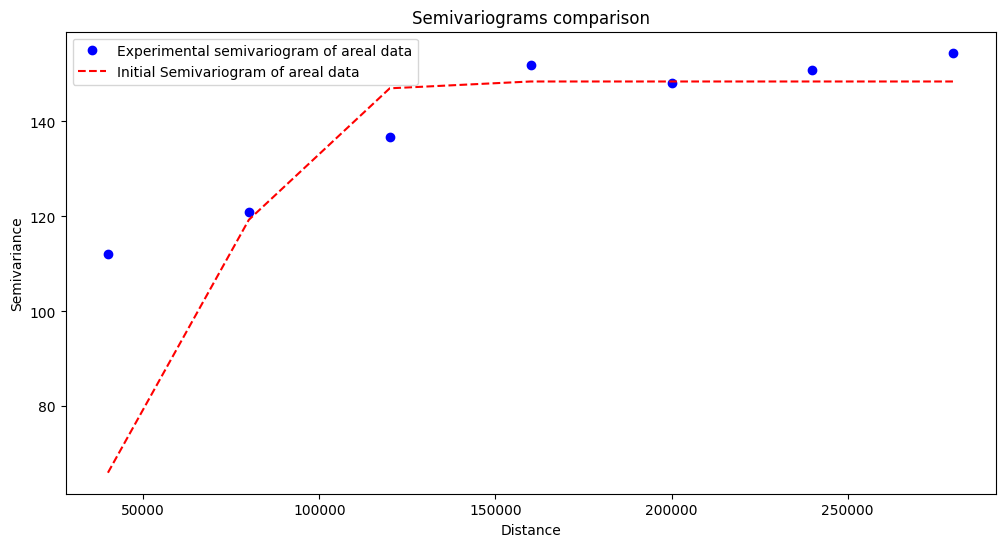

In [11]:
# Check initial experimental, theoretical and regularized semivariograms
reg_mod.plot_variograms()

After fitting, when we check how initial semivariogram behaves, we can perform `transform()` operation. This function has few parameters to control the regularization process, but we leave them as default with one exception: we set the `max_iters` parameter to 5.

This process of fitting and transforming takes some time, so it's a good idea to run it and go for lunch...

In [12]:
reg_mod.transform(
    max_iters=5
)

Transform procedure starts


100%|██████████| 5/5 [05:04<00:00, 60.89s/it]


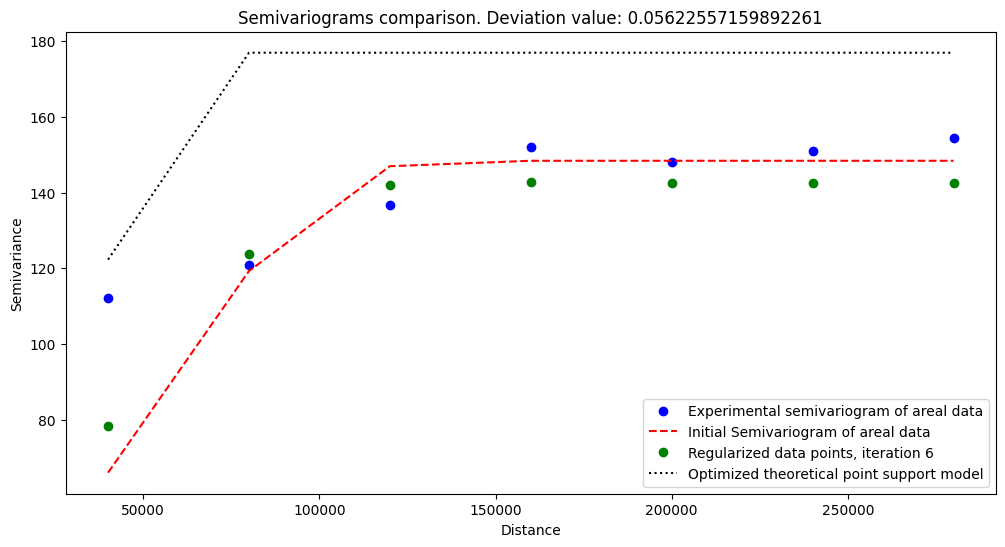

In [13]:
reg_mod.plot_variograms()

## 4. Visualize process

The process is automatic, but we can check how it behaved through each iteration. We can analyze deviation change (the most important variable, the mean absolute difference between regularized and theoretical models) with the built-in method. Still, if we are more interested in the algorithm stability, we can analyze weight changes during each iteration.

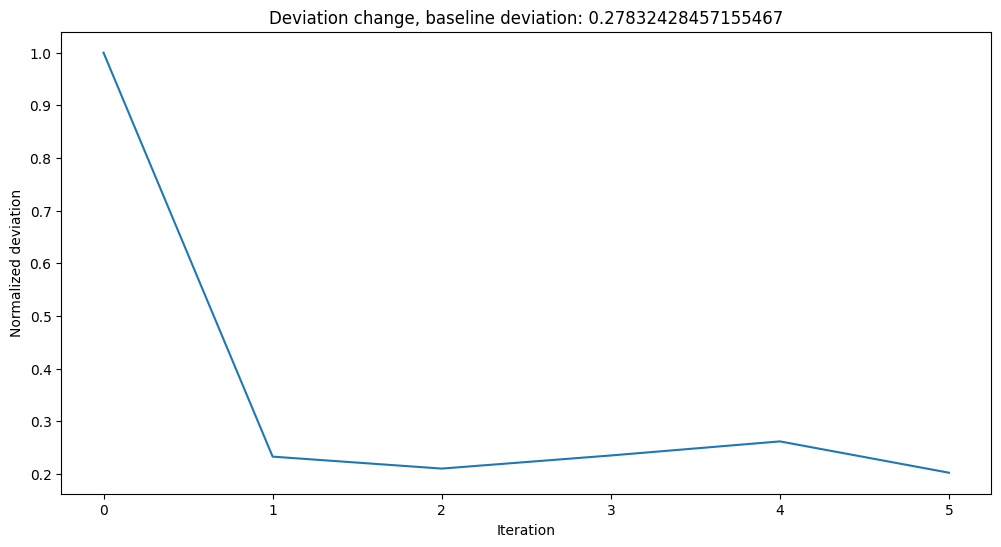

In [14]:
reg_mod.plot_deviation_change(normalized=True)

**Clarification**: The deviation between a regularized semivariogram and a theoretical model decreases with each iteration. However, a significant improvement can be seen after the first step, and then it slows down. That's why semivariogram regularization usually does not require many steps. However, if there are many lags, optimization may require more steps to achieve a meaningful result.

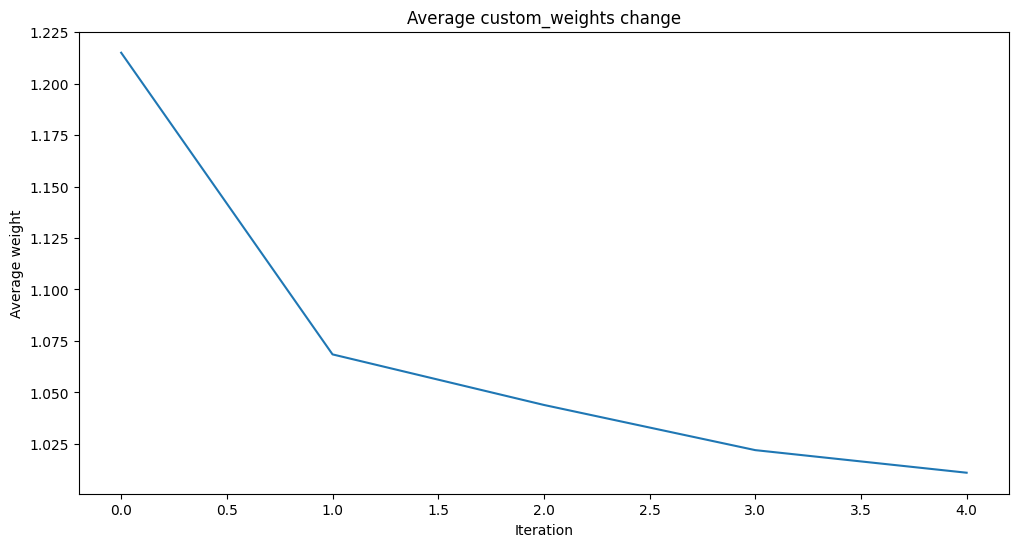

In [15]:
reg_mod.plot_weights_change()

Weights check is important to track problems with algorithm, especially if average weight oscillates. This may be a sign of problems with data, or modeling assumptions.

Weights are smaller with each iteration. It is the expected behavior of the algorithm. The general trend goes downward, and small oscillations may occur due to the optimization process.

The most important part is to compare semivariograms! We have plotted those before, but now we do it again.

Regularized Model is different from the initial semivariogram. It is the result of regularization, where the areal aggregates are distributed along population point support blocks.

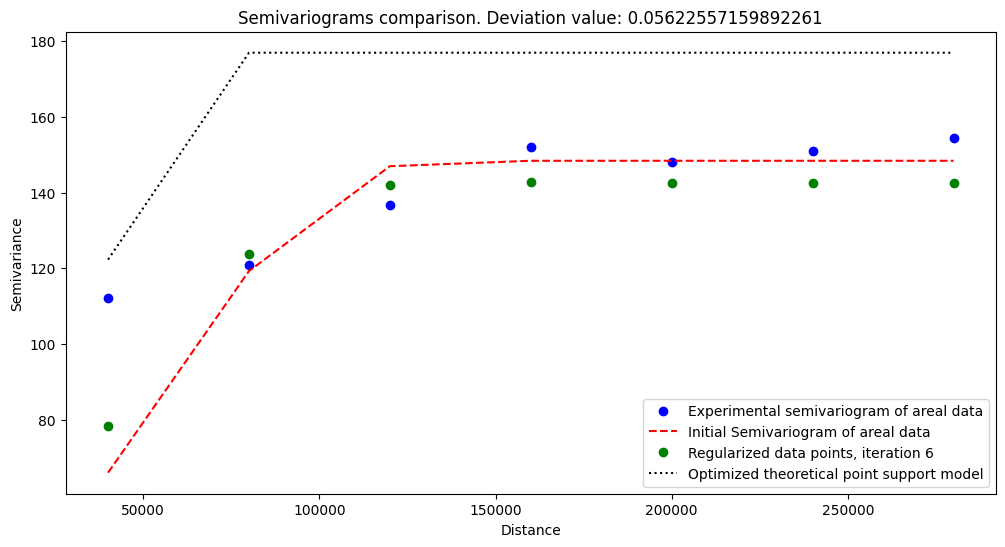

In [16]:
reg_mod.plot_variograms()

The regularized model works well and follows general trends. It assigns smaller weights for closest lags, and for more significant distances, weights are bigger. It is related to the semivariogram weighting method - we penalize more poorly performing models for the shortest distances from the origin.

## 5. Export semivariogram

After so long process we shouldn't forget about saving modeling results! Thus, we will export regularized semivariogram and store it for Poisson Kriging.

In [17]:
reg_mod.export_model_to_json(OUTPUT)

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-05-21 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |